In [67]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [ ]:
dt = 0.03
deposit_entry = 7
U_avg = 0.6586
N0_particle = 100
St0 = 0.5
full_particle_set = set(float(i) for i in range(N0_particle))
R0 = 1 # THIS is the core radius from the origin
timesteps = 

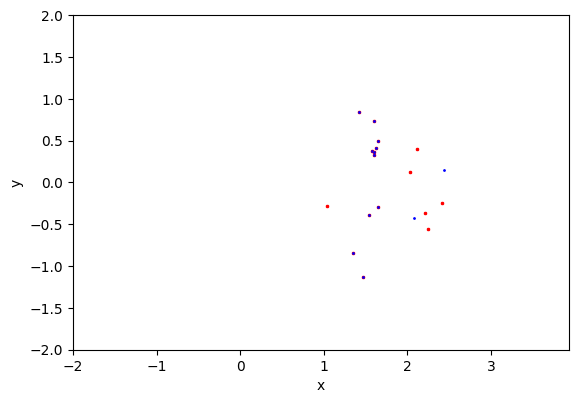

In [69]:
# load deposit_dict.pkl to extract time steps with deposits
folder_path = f'lineplume_sims_3D/temp/'

# Load the data
with open(folder_path + 'deposit_dict.pkl', 'rb') as f:
    deposit_dict = pickle.load(f)

deposit_frames = []
deposit_from_upper_core_ids = set()
deposit_from_lower_core_ids = set()

fig, ax = plt.subplots()

for time, deposit in deposit_dict.items():
    if deposit is not None:
        time = round(time, 3)

        # extract id and incore_fraction
        ids = deposit[: int(len(deposit)/deposit_entry)]
        incore_fraction_upper = deposit[-2*int(len(deposit)/deposit_entry):-int(len(deposit)/deposit_entry)]
        incore_fraction_lower = deposit[-int(len(deposit)/deposit_entry):]

        # collect id's with incore_fraction > 0
        if incore_fraction_upper.any() > 0:
            deposit_frames.append(int(time/dt + 1))
            deposit_from_upper_core_ids.update(ids[incore_fraction_upper > 0])

            x_loc = deposit[int(len(deposit)/deposit_entry): 2*int(len(deposit)/deposit_entry)]
            y_loc = deposit[2*int(len(deposit)/deposit_entry): 3*int(len(deposit)/deposit_entry)]
            ax.scatter(x_loc[incore_fraction_upper >0] + U_avg * time, y_loc[incore_fraction_upper>0], c='r', s=3, marker='x')  

        if incore_fraction_lower.any() > 0:
            deposit_frames.append(int(time/dt + 1))
            deposit_from_lower_core_ids.update(ids[incore_fraction_lower > 0])

            x_loc = deposit[int(len(deposit)/deposit_entry): 2*int(len(deposit)/deposit_entry)]
            y_loc = deposit[2*int(len(deposit)/deposit_entry): 3*int(len(deposit)/deposit_entry)]
            ax.scatter(x_loc[incore_fraction_lower >0] + U_avg * time, y_loc[incore_fraction_lower>0], c='b', s=1)
    
    ax.set_xlim(-2, round(time * U_avg, 3))
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    # ax.legend()


In [91]:
timesteps = np.arange(len(deposit_dict))

In [160]:
def plot_trajectories(id_set, folder_path):

    # Initialize a dictionary to store the trajectories
    trajectories = {pid: [] for pid in id_set}
    azimuthals = {pid: [] for pid in id_set}
    radials_2d = {pid: [] for pid in id_set}

    # Loop through each file in the directory
    for i in range(1, len(deposit_dict)+1):  # Adjust the range according to your frame count
        file_path = os.path.join(folder_path, f'frame_{i}.npy')
        if os.path.exists(file_path):
            # Load the data from the file
            data = np.load(file_path)

            # Create a set of particle IDs in this frame for quick lookup
            current_particles = set(data[:, 0])

            # Extract data for each particle of interest
            for pid in id_set:
                if pid in current_particles:
                    # Find the index of the particle in the current frame
                    index = np.where(data[:, 0] == pid)[0][0]

                    # Append the particle's data (excluding the ID) to its trajectory
                    trajectories[pid].append(data[index, 1:4])
                    x = data[index, 1]
                    y = data[index, 2]
                    z = data[index, 3]

                    # compute azimuthal and radial coordinates
                    azi = np.degrees(np.arctan(z/np.sqrt(x**2 + y**2)))
                    if y < 0 and z > 0:
                        azi = 180 - azi
                    if y < 0 and z < 0:
                        azi = - 180 - azi

                    # find the coordinate of the 2d-core center
                    X_prime = 0
                    Y_prime = (R0 * np.sqrt(x**2 + y**2) / np.sqrt(x**2 + y**2 + z**2)) * np.sign(y)
                    Z_prime = (R0 * z / np.sqrt(x**2 + y**2 + z**2))
                    
                    radsq = (x - X_prime)**2 + (y - Y_prime)**2 + (z - Z_prime)**2

                    azimuthals[pid].append(azi)
                    radials_2d[pid].append(np.sqrt(radsq))
                    
                else:
                    # Append None or numpy.nan to indicate missing particle in this frame
                    trajectories[pid].append(None)

    # Now, 'trajectories' contains the time series data for each particle of interest

    # Create a new figure for plotting
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    fig2, ax2 = plt.subplots()
    cmap = plt.get_cmap('viridis')

    # # Plot each trajectory
    for pid, trajectory in trajectories.items():
        # trajectory = trajectories[pid]
        # Extract x, y, z coordinates, handling None values
        x_coords = [point[0] if point is not None else np.nan for point in trajectory]
        y_coords = [point[1] if point is not None else np.nan for point in trajectory]
        z_coords = [point[2] if point is not None else np.nan for point in trajectory]

        # Plot the trajectory
        ax.scatter(x_coords, y_coords, z_coords, s=1)
        # ax2.scatter(np.arange(len(azimuthals[pid])), azimuthals[pid], s= 1)
        scatter = ax2.scatter(radials_2d[pid], azimuthals[pid], c=np.arange(len(azimuthals[pid])), cmap=cmap, vmin= 0, vmax= len(timesteps), s=1)


    # Labels and legend
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')

    ax.set_xlim3d(-2, 2)
    ax.set_ylim3d(-2, 2)
    ax.set_zlim3d(-2, 2)

    ax.view_init(elev=0, azim=270)

    # ax2.set_ylim(-270, 90)
    # ax2.set_ylim(0, 2)
    cbar = fig2.colorbar(scatter, ax=ax2)
    cbar.set_label('Time step')

    # Show the plot
    # plt.tight_layout()
    plt.show()

    return radials_2d, azimuthals, trajectories

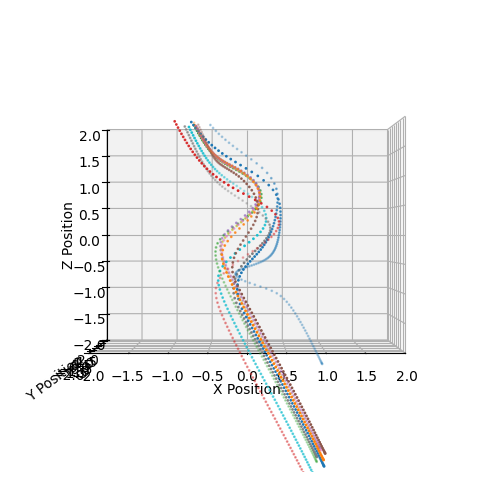

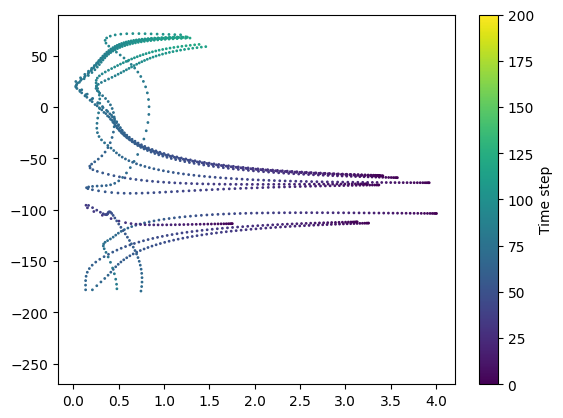

In [159]:
escape_particles = deposit_from_upper_core_ids.union(deposit_from_lower_core_ids)

target_set = deposit_from_upper_core_ids.intersection(deposit_from_lower_core_ids)

radials_2d, _, trajectories = plot_trajectories(target_set, folder_path)

find steady state  behavior (in-core volume stabilised)

In [121]:
from matplotlib.path import Path
path = 'velocity_fields/alpha_0.4_2D/'

geometry_2D = np.load(path + 'geometry.npy')

x_core_2d, y_core_2d, y_core_lower_2d, _, _ = geometry_2D.T

def incore_volume(df):
    x_2d = df[:, 1]
    y_2d = np.sqrt(df[:, 2]**2 + df[:, 3]**2) * np.sign(df[:, 3])
    in_upper_core = Path(np.vstack([x_core_2d, y_core_2d]).T).contains_points(np.vstack([x_2d, y_2d]).T)
    upper_core_volume = np.sum(np.power(df[in_upper_core, 7], 1.5))
    in_lower_core = Path(np.vstack([x_core_2d, y_core_lower_2d]).T).contains_points(np.vstack([x_2d, y_2d]).T)
    lower_core_volume = np.sum(np.power(df[in_lower_core, 7], 1.5))
    return upper_core_volume, lower_core_volume


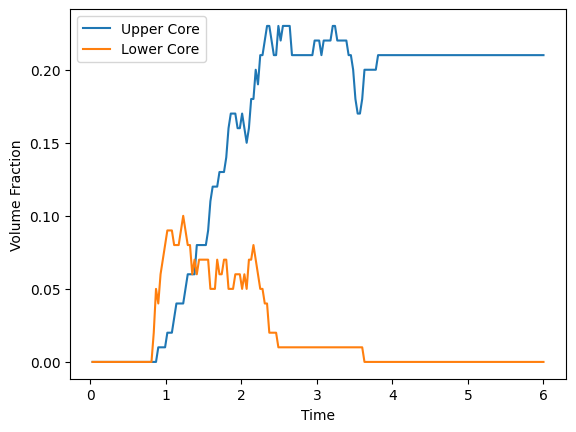

In [122]:
fig, ax = plt.subplots()

upper_core_volume = []
lower_core_volume = []
plume_volume = N0_particle * (St0**1.5)

for i in range(1, len(deposit_dict)+1):
    df = np.load(folder_path + f'frame_{i}.npy')
    up_v, low_v = incore_volume(df)
    upper_core_volume.append(up_v)
    lower_core_volume.append(low_v)

ax.plot(np.arange(1, len(deposit_dict)+1) * dt, np.array(upper_core_volume)/plume_volume, label='Upper Core')
ax.plot(np.arange(1, len(deposit_dict)+1) * dt, np.array(lower_core_volume)/plume_volume, label='Lower Core')
ax.set_xlabel('Time')
ax.set_ylabel('Volume Fraction')
ax.legend()

detect steady state of entrainment

In [123]:
diff = np.abs(np.diff(np.array(upper_core_volume))/plume_volume)
threshold = 1e-15
time_points = np.arange(1, len(deposit_dict)+1) * dt
rolling_window = 30

# Find the first point where changes stay below the threshold for a consecutive number of points
for i in range(1, len(diff)):
    if np.all(diff[i:i+rolling_window] < threshold) and upper_core_volume[i] != 0:  # Checking over a span of 5 points, for example
        steady_state_frame = i
        steady_state_fraction = upper_core_volume[i]/plume_volume
        break

print("Steady state reached at time:", steady_state_frame, "and steady state volume fraction:", steady_state_fraction)

Steady state reached at time: 126 and steady state volume fraction: 0.21


extract bubbles that get entrained

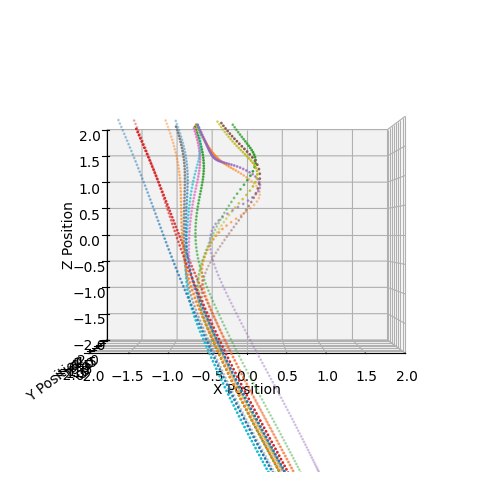

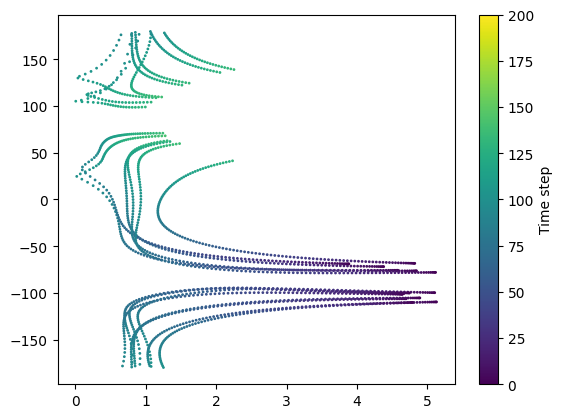

In [155]:
steady_state_df = np.load(folder_path + f'frame_{steady_state_frame+1}.npy')

x_2d = steady_state_df[:, 1]
y_2d = np.sqrt(steady_state_df[:, 2]**2 + steady_state_df[:, 3]**2) * np.sign(steady_state_df[:, 3])
stay_in_upper_core = Path(np.vstack([x_core_2d, y_core_2d]).T).contains_points(np.vstack([x_2d, y_2d]).T)
entrained_ids  = set(steady_state_df[stay_in_upper_core, 0])
what_are_you = set(steady_state_df[~stay_in_upper_core, 0])
_, _, trajectories  = plot_trajectories(what_are_you, folder_path)


In [ ]:
# id = 5.0
# trajectory = trajectories[id]

# # Extract x, y, z coordinates at steady state
# shift = 3
# x = x_coords[steady_state_frame+shift]
# y = y_coords[steady_state_frame+shift]
# z = z_coords[steady_state_frame+    shift]
# x_2d = x
# y_2d = np.sqrt(y**2 + z**2) * np.sign(z)
# stay_in_upper_core = Path(np.vstack([x_core_2d, y_core_2d]).T).contains_points(np.vstack([x_2d, y_2d]).T)
# stay_in_upper_core

KeyError: 5.0

The ones that never enter the core

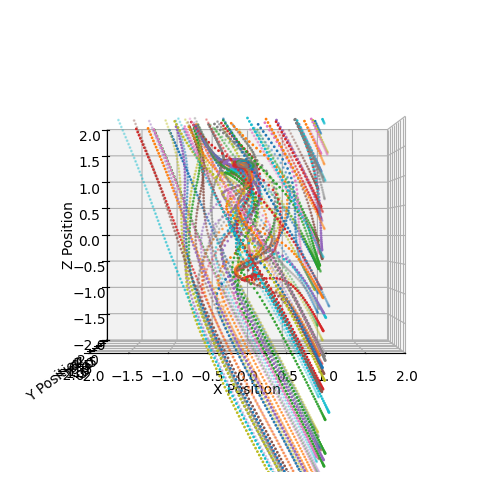

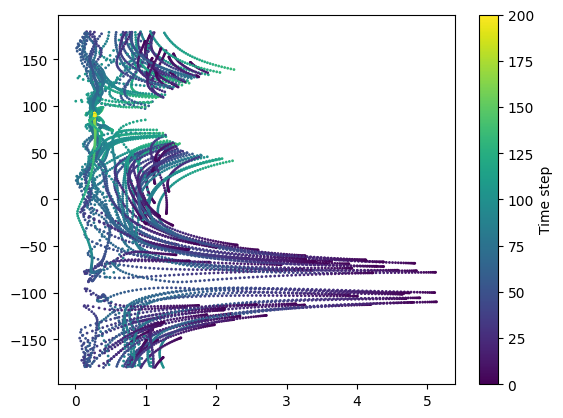

In [162]:
attracted_ids = escape_particles.union(entrained_ids)
lost_particles = full_particle_set.difference(attracted_ids)

_, _, _ = plot_trajectories(full_particle_set, folder_path)